In [51]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import statsmodels.api as sm

In [52]:
from HMM_main import *

In [53]:
## 
# df_result = pd.read_csv('results/aggregate_results.csv')
df_result = pd.read_csv('results/aggregate_results_imputed.csv')
countries_info = pd.read_csv('data/dl1_countrycodeorg_country_name.csv')
ConsiderTC, ConsiderMB, informal, discount, scenario = 1, 1, 0.05, 0.02, 'val'

def get_df(df_result, ConsiderTC, ConsiderMB, informal, discount, scenario):
    df = df_result[(df_result['discount']==discount)&
                   (df_result['ConsiderTC']==ConsiderTC)&
                   (df_result['ConsiderMB']==ConsiderMB)&
                   (df_result['informal']==informal)&
                   (df_result['scenario']==scenario)]
    df = df[df['tax'] > 0]
    return df

In [29]:
df_analysis = get_df(df_result, ConsiderTC, ConsiderMB, informal, discount, scenario)
df_tax = df_analysis.groupby('Country Code').sum()
print (df_tax.describe())

       ConsiderTC  ConsiderMB      informal      discount       GDPloss  \
count       204.0       204.0  2.040000e+02  2.040000e+02    204.000000   
mean          1.0         1.0  5.000000e-02  2.000000e-02    260.059125   
std           0.0         0.0  4.869175e-17  3.477982e-18   1163.283813   
min           1.0         1.0  5.000000e-02  2.000000e-02      0.003939   
25%           1.0         1.0  5.000000e-02  2.000000e-02      3.198243   
50%           1.0         1.0  5.000000e-02  2.000000e-02     19.974589   
75%           1.0         1.0  5.000000e-02  2.000000e-02    128.003188   
max           1.0         1.0  5.000000e-02  2.000000e-02  11924.288666   

              tax       pc_loss  
count  204.000000    204.000000  
mean     0.010314   8044.481730  
std      0.004844  11643.267237  
min      0.002143     36.049846  
25%      0.006693   1097.214308  
50%      0.009994   3668.496245  
75%      0.013374  11309.819065  
max      0.028398  96830.263611  


## Prevalence

In [30]:
## IHME data 2019
df_IHME = pd.read_csv('bigdata/data_diabetes/IHME.csv')
df_IHME = df_IHME[(df_IHME['year']==2019) & (df_IHME['metric']=='Rate')]
df_IHME = df_IHME.rename(columns={'location':'country'})
cn = countries_info[["Country Code", "country"]]
df_IHME = df_IHME.merge(cn, on='country',how='inner')
df_IHME = df_IHME[['Country Code','cause','val','measure']]
IHME_data = pd.pivot_table(df_IHME, columns='measure',values='val',index=['Country Code']).reset_index()

## IHME data 2020-2050, average
prev = pd.read_csv('bigdata/data_diabetes/prevalence_val.csv').set_index(['Country Code', 'sex', 'age']).drop(columns=['disease'])
pop = pd.read_csv('data/population_un.csv').set_index(['Country Code', 'sex', 'age'])
PREVs = prev * pop
PREVs = PREVs.reset_index().dropna(axis=1,how='all').dropna(axis=0)
PREV = PREVs.groupby(['Country Code']).sum()
PREV = [PREV[str(year)] for year in range(2020, 2051)]
PREV = pd.concat(PREV,axis=1)
POP = pop.groupby(['Country Code']).sum().reset_index()
POP = POP[POP['Country Code'].isin(PREV.index.values)].set_index('Country Code')
POP = [POP[str(year)] for year in range(2020, 2051)]
POP = pd.concat(POP,axis=1)

PREV_RATE = PREV / POP
PREV_RATE = PREV_RATE.mean(axis=1) * 100000
# PREV_RATE = PREV_RATE.reset_index()
PREV_RATE = pd.DataFrame(PREV_RATE, columns=['Prevalence']).reset_index()
# IHME_data = PREV_RATE

In [31]:
data = df_tax.merge(IHME_data[['Country Code', 'Prevalence']], on='Country Code')
income = countries_info[['Country Code', 'Income group']]
data = data.merge(income, on='Country Code')
x = data[['Prevalence']].apply(np.log10)
# x = data[['Prevalence']]
X = sm.add_constant(x)
# y = 100 * data[['tax']]
y = data[['tax']].apply(np.log10)
# y = data[['tax']]
ols_model = sm.OLS(y, X)
ols_results = ols_model.fit()
print("Parameters: ", ols_results.params)
print("R2: ", ols_results.rsquared)

Parameters:  const        -4.734950
Prevalence    0.717927
dtype: float64
R2:  0.8313668366396926


/Users/caozhong/miniconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


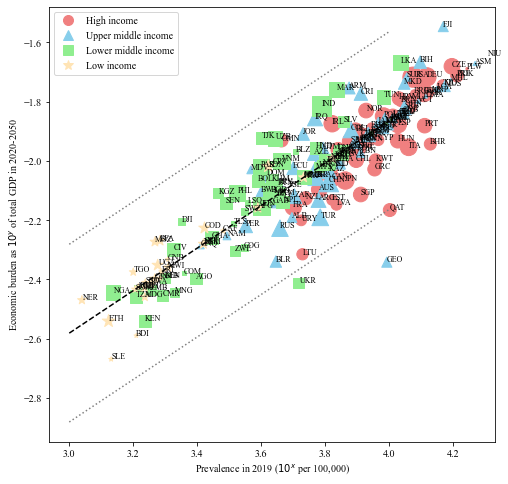

In [32]:

# plt.rcParams['font.family']='Courier New, monospace'
plt.rcParams["font.family"] = "Times New Roman"
fig, ax = plt.subplots(figsize=(8,8))

colors = {'High income': 'lightcoral', 'Upper middle income' : 'skyblue', 'Lower middle income': 'lightgreen', 
       'Low income': 'moccasin'}
markers = {'High income': 'o', 'Upper middle income' : '^', 'Lower middle income': 's', 
       'Low income': '*'}
income_group = ['High income', 'Upper middle income', 'Lower middle income',  'Low income']

legends = []
for income in income_group:
    legend = mlines.Line2D([], [], color=colors[income], marker=markers[income], linestyle='None',
                          markersize=10, label=income)
    legends.append(legend)
plt.legend(handles=legends)
      

for income in income_group:
    area = data[data['Income group'] == income]
    x = area[['Prevalence']].apply(np.log10)
    y = area[['tax']].apply(np.log10)
    # y = 100 * area[['tax']]
    ax.scatter(x, y, c = colors[income], marker = markers[income], s = 30 * (area['GDPloss'] + 1).apply(np.log2))

# countries = ['CHN', 'USA', 'IND', 'MCO', 'BGR', 'SRB', 'HUN', 'BRN', 'DOM', 'LBN', 'PRT', 'GRC']
# countries = ['MCO', 'IRL', 'BMU', 'BDI', 'SOM', 'LBN', 'USA', 'CHN', 'IND']
countries = data['Country Code']
# countries = ['CHN', 'USA', 'IND']
for country in countries:
    i = data[data['Country Code'] == country].index.values[0]
    x_i, y_i = np.log10(data.loc[i, 'Prevalence']), np.log10(data.loc[i, 'tax'])
    ax.annotate(country, (x_i, y_i), size=8)

x1, x2 = 3.0, 4.0
plt.plot([x1, x2], [ols_results.params[0]+x1 * ols_results.params[1], ols_results.params[0]+x2 * ols_results.params[1]], linestyle='--', color='black')
plt.plot([x1, x2], [0.3 + ols_results.params[0]+x1 * ols_results.params[1], 0.3 + ols_results.params[0]+x2 * ols_results.params[1]], linestyle=':', color='grey')
plt.plot([x1, x2], [-0.3 + ols_results.params[0]+x1 * ols_results.params[1], -0.3 + ols_results.params[0]+x2 * ols_results.params[1]], linestyle=':', color='grey')

plt.ylabel('Economic burden as $10^y$ of total GDP in 2020-2050')
plt.xlabel('Prevalence in 2019 ($10^x$ per 100,000)')
plt.savefig('tables/figure_SS5.pdf')

## Deaths

In [33]:
## motality
# mortality = pd.read_csv('bigdata/Total cancers/Deaths.csv')

In [34]:
# data = df_tax.merge(mortality, on='Country Code')
# income = countries_info[['Country Code', 'Income group']]
# data = data.merge(income, on='Country Code')
# x = data[['Deaths']]
# X = sm.add_constant(x)
# y = 100 * data[['tax']]
# ols_model = sm.OLS(y, X)
# ols_results = ols_model.fit()
# print("Parameters: ", ols_results.params)
# print("R2: ", ols_results.rsquared)

In [35]:

# plt.rcParams['font.family']='Courier New, monospace'
# fig, ax = plt.subplots(figsize=(8,8))
# #
# colors = {'High income': 'lightcoral', 'Upper middle income' : 'skyblue', 'Lower middle income': 'lightgreen', 
#        'Low income': 'moccasin'}
# markers = {'High income': 'o', 'Upper middle income' : '^', 'Lower middle income': 's', 
#        'Low income': '*'}
# income_group = ['High income', 'Upper middle income', 'Lower middle income',  'Low income']

# legends = []
# for income in income_group:
#     legend = mlines.Line2D([], [], color=colors[income], marker=markers[income], linestyle='None',
#                           markersize=10, label=income)
#     legends.append(legend)
# plt.legend(handles=legends)
      

# for income in income_group:
#     area = data[data['Income group'] == income]
#     x = area[['Deaths']]
#     y = 100 * area[['tax']]
#     ax.scatter(x, y, c = colors[income], marker = markers[income], s = 30 * (area['GDPloss'] + 1).apply(np.log2))

# countries = ['CHN', 'USA', 'IND', 'MCO', 'BGR', 'SRB', 'BRN', 'LBN', 'PRT', 'GRC', 'SVK', 'UKR']
# # countries = data['Country Code']
# for country in countries:
#     i = data[data['Country Code'] == country].index.values[0]
#     x_i, y_i = data.loc[i, 'Deaths'], 100 * data.loc[i, 'tax']
#     ax.annotate(country, (x_i, y_i), size=8)
# # i = data[data['Country Code'] == 'GEO'].index.values[0]    
# # x_i, y_i = data.loc[i, 'Deaths'] - 500, 100 * data.loc[i, 'tax']
# # ax.annotate('GEO', (x_i, y_i), size=8)
# # i = data[data['Country Code'] == 'UKR'].index.values[0]    
# # x_i, y_i = data.loc[i, 'Deaths'] + 200, 100 * data.loc[i, 'tax']
# # ax.annotate('UKR', (x_i, y_i), size=8)
# # i = data[data['Country Code'] == 'SVK'].index.values[0]    
# # x_i, y_i = data.loc[i, 'Deaths'], 100 * data.loc[i, 'tax'] - 0.06
# # ax.annotate('SVK', (x_i, y_i), size=8)

# x1, x2 = 0, 600
# plt.plot([x1, x2], [ols_results.params[0]+x1 * ols_results.params[1], ols_results.params[0]+x2 * ols_results.params[1]], linestyle='--', color='black')
# plt.plot([x1, x2], [0.3 + ols_results.params[0]+x1 * ols_results.params[1], 0.3 + ols_results.params[0]+x2 * ols_results.params[1]], linestyle=':', color='grey')
# plt.plot([x1, x2], [-0.3 + ols_results.params[0]+x1 * ols_results.params[1], -0.3 + ols_results.params[0]+x2 * ols_results.params[1]], linestyle=':', color='grey')

# plt.ylabel('Economic burden as percentage of total GDP in 2020-2050 (%)')
# plt.xlabel('Mortality in 2019 (per 100,000)')
# plt.savefig('tables/figure_6.pdf')

## GDP

In [36]:
TOTAL_GDP = pd.read_csv('tmpresults/GDP_TOTAL_discount0.02.csv')
TOTAL_GDP['averageGDP'] = TOTAL_GDP['totalGDP'] / 1000000000 / (2051 - 2020)
# data2['averagePOP'] = data2['totalPOP'] / 1000000 / (self.endyear - self.projectStartYear)

In [37]:
data = df_tax.merge(TOTAL_GDP, on='Country Code')
income = countries_info[['Country Code', 'Income group']]
data = data.merge(income, on='Country Code')
x = data[['averageGDP']].apply(np.log10)
X = sm.add_constant(x)
y = data[['GDPloss']].apply(np.log10)
ols_model = sm.OLS(y, X)
ols_results = ols_model.fit()
print("Parameters: ", ols_results.params)
print("R2: ", ols_results.rsquared)

Parameters:  const        -0.505962
averageGDP    0.976753
dtype: float64
R2:  0.9603663097997828


/Users/caozhong/miniconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


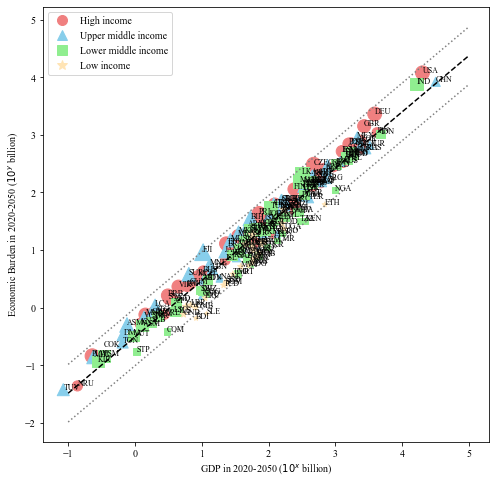

In [38]:

# plt.rcParams['font.family']='Courier New, monospace'
plt.rcParams["font.family"] = "Times New Roman"
fig, ax = plt.subplots(figsize=(8,8))

colors = {'High income': 'lightcoral', 'Upper middle income' : 'skyblue', 'Lower middle income': 'lightgreen', 
       'Low income': 'moccasin'}
markers = {'High income': 'o', 'Upper middle income' : '^', 'Lower middle income': 's', 
       'Low income': '*'}
income_group = ['High income', 'Upper middle income', 'Lower middle income',  'Low income']

legends = []
for income in income_group:
    legend = mlines.Line2D([], [], color=colors[income], marker=markers[income], linestyle='None',
                          markersize=10, label=income)
    legends.append(legend)
plt.legend(handles=legends)
      

for income in income_group:
    area = data[data['Income group'] == income]
    x = area[['averageGDP']].apply(np.log10)
    y = area[['GDPloss']].apply(np.log10)
    ax.scatter(x, y, c = colors[income], marker = markers[income], s = 100 * 100 * area['tax'])

# countries = ['CHN', 'USA', 'IND']
countries = data['Country Code']
for country in countries:
    i = data[data['Country Code'] == country].index.values[0]
    x_i, y_i = np.log10(data.loc[i, 'averageGDP']), np.log10(data.loc[i, 'GDPloss'])
    ax.annotate(country, (x_i, y_i), size=8)
# i = data[data['Country Code'] == 'GEO'].index.values[0]    
# x_i, y_i = data.loc[i, 'averageGDP'] - 500, 100 * data.loc[i, 'GDPloss']
# ax.annotate('GEO', (x_i, y_i), size=8)
# i = data[data['Country Code'] == 'UKR'].index.values[0]    
# x_i, y_i = data.loc[i, 'averageGDP'] + 200, 100 * data.loc[i, 'GDPloss']
# ax.annotate('UKR', (x_i, y_i), size=8)
# i = data[data['Country Code'] == 'SVK'].index.values[0]    
# x_i, y_i = data.loc[i, 'averageGDP'], 100 * data.loc[i, 'GDPloss'] - 0.06
# ax.annotate('SVK', (x_i, y_i), size=8)

x1, x2 = -1, 5
plt.plot([x1, x2], [ols_results.params[0]+x1 * ols_results.params[1], ols_results.params[0]+x2 * ols_results.params[1]], linestyle='--', color='black')
plt.plot([x1, x2], [0.5 + ols_results.params[0]+x1 * ols_results.params[1], 0.5 + ols_results.params[0]+x2 * ols_results.params[1]], linestyle=':', color='grey')
plt.plot([x1, x2], [-0.5 + ols_results.params[0]+x1 * ols_results.params[1], -0.5 + ols_results.params[0]+x2 * ols_results.params[1]], linestyle=':', color='grey')

plt.ylabel('Economic Burden in 2020-2050 ($10^y$ billion)')
plt.xlabel('GDP in 2020-2050 ($10^x$ billion)')
plt.savefig('tables/figure_SS7.pdf')

## Population

In [39]:
# TOTAL_POP = pd.read_csv('data/POP_TOTAL.csv')
# TOTAL_POP['averagePOP'] = TOTAL_POP['totalPOP'] / 1000000 / (2051 - 2020)

In [40]:
# data = df_tax.merge(TOTAL_POP, on='Country Code')
# income = countries_info[['Country Code', 'Income group']]
# data = data.merge(income, on='Country Code')
# x = data[['averagePOP']].apply(np.log10)
# X = sm.add_constant(x)
# y = data[['GDPloss']].apply(np.log10)
# # y = data[['tax']]
# ols_model = sm.OLS(y, X)
# ols_results = ols_model.fit()
# print("Parameters: ", ols_results.params)
# print("R2: ", ols_results.rsquared)

In [41]:
# plt.rcParams['font.family']='Courier New, monospace'
# fig, ax = plt.subplots(figsize=(8,8))

# colors = {'High income': 'lightcoral', 'Upper middle income' : 'skyblue', 'Lower middle income': 'lightgreen', 
#        'Low income': 'moccasin'}
# markers = {'High income': 'o', 'Upper middle income' : '^', 'Lower middle income': 's', 
#        'Low income': '*'}
# income_group = ['High income', 'Upper middle income', 'Lower middle income',  'Low income']

# legends = []
# for income in income_group:
#     legend = mlines.Line2D([], [], color=colors[income], marker=markers[income], linestyle='None',
#                           markersize=10, label=income)
#     legends.append(legend)
# plt.legend(handles=legends)
      

# for income in income_group:
#     area = data[data['Income group'] == income]
#     x = area[['averagePOP']].apply(np.log10)
#     y = area[['GDPloss']].apply(np.log10)
#     ax.scatter(x, y, c = colors[income], marker = markers[income], s = 100 * 100 * area['tax'])

# countries = ['CHN', 'USA', 'IND', 'MCO']
# # countries = data['Country Code']
# for country in countries:
#     i = data[data['Country Code'] == country].index.values[0]
#     x_i, y_i = np.log10(data.loc[i, 'averagePOP']), np.log10(data.loc[i, 'GDPloss'])
#     ax.annotate(country, (x_i, y_i), size=8)

# plt.ylabel('Economic Burden in 2020-2050 ($10^y$ billion)')
# plt.xlabel('Average Population in 2020-2050 ($10^x$ million)')
# plt.savefig('tables/figure_8.pdf')

In [42]:
TOTAL_GDP = pd.read_csv('tmpresults/GDP_TOTAL_discount0.02.csv')
TOTAL_GDP['averageGDP'] = TOTAL_GDP['totalGDP'] / 1000000000 / (2051 - 2020)
TOTAL_POP = pd.read_csv('tmpresults/POP_TOTAL.csv')
TOTAL_POP['averagePOP'] = TOTAL_POP['totalPOP'] / 1000000 / (2051 - 2020)
TOTAL_DATA = TOTAL_GDP.merge(TOTAL_POP, on=['Country Code'])
TOTAL_DATA['pc_GDP'] = TOTAL_DATA['averageGDP'] / TOTAL_DATA['averagePOP']

## Per Capita Loss

In [43]:
data = df_tax.merge(TOTAL_DATA, on='Country Code')
income = countries_info[['Country Code', 'Income group']]
data = data.merge(income, on='Country Code')
x = data[['pc_GDP']].apply(np.log10)
X = sm.add_constant(x)
y = data[['pc_loss']].apply(np.log10)
ols_model = sm.OLS(y, X)
ols_results = ols_model.fit()
print("Parameters: ", ols_results.params)
print("R2: ", ols_results.rsquared)

Parameters:  const     2.214582
pc_GDP    1.226323
dtype: float64
R2:  0.9251230115394087


/Users/caozhong/miniconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


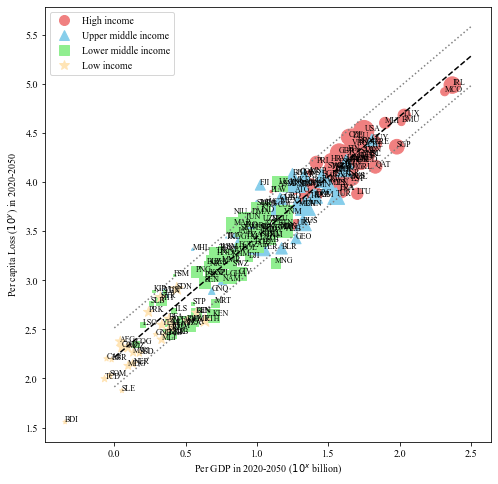

In [44]:

# plt.rcParams['font.family']='Courier New, monospace'
plt.rcParams["font.family"] = "Times New Roman"
fig, ax = plt.subplots(figsize=(8,8))

colors = {'High income': 'lightcoral', 'Upper middle income' : 'skyblue', 'Lower middle income': 'lightgreen', 
       'Low income': 'moccasin'}
markers = {'High income': 'o', 'Upper middle income' : '^', 'Lower middle income': 's', 
       'Low income': '*'}
income_group = ['High income', 'Upper middle income', 'Lower middle income',  'Low income']

legends = []
for income in income_group:
    legend = mlines.Line2D([], [], color=colors[income], marker=markers[income], linestyle='None',
                          markersize=10, label=income)
    legends.append(legend)
plt.legend(handles=legends)
      

for income in income_group:
    area = data[data['Income group'] == income]
    x = area[['pc_GDP']].apply(np.log10)
    y = area[['pc_loss']].apply(np.log10)
    ax.scatter(x, y, c = colors[income], marker = markers[income], s = 30 * (area['GDPloss'] + 1).apply(np.log2))


# countries = ['MCO', 'BMU', 'CHN', 'USA', 'IND']
# countries = ['MCO', 'BMU', 'BDI', 'SOM', 'LBN', 'USA', 'CHN', 'IND']
countries = data['Country Code']
for country in countries:
    i = data[data['Country Code'] == country].index.values[0]
    x_i, y_i = np.log10(data.loc[i, 'pc_GDP']), np.log10(data.loc[i, 'pc_loss'])
    ax.annotate(country, (x_i, y_i), size=8)


x1, x2 = 0, 2.5
plt.plot([x1, x2], [ols_results.params[0]+x1 * ols_results.params[1], ols_results.params[0]+x2 * ols_results.params[1]], linestyle='--', color='black')
plt.plot([x1, x2], [0.3 + ols_results.params[0]+x1 * ols_results.params[1], 0.3 + ols_results.params[0]+x2 * ols_results.params[1]], linestyle=':', color='grey')
plt.plot([x1, x2], [-0.3 + ols_results.params[0]+x1 * ols_results.params[1], -0.3 + ols_results.params[0]+x2 * ols_results.params[1]], linestyle=':', color='grey')

plt.ylabel('Per capita Loss ($10^y$) in 2020-2050')
plt.xlabel('Per GDP in 2020-2050 ($10^x$ billion)')
plt.savefig('tables/figure_SS6.pdf')

## Per Capita for DALYs

In [45]:
# ## DALYs
# DALYs = pd.read_csv('bigdata/Total cancers/DALYs (Disability-Adjusted Life Years).csv')

In [46]:
# data = df_tax.merge(DALYs, on='Country Code')
# income = countries_info[['Country Code', 'Income group']]
# data = data.merge(income, on='Country Code')
# x = data[['DALYs (Disability-Adjusted Life Years)']].apply(np.log10)
# X = sm.add_constant(x)
# y = data[['pc_loss']].apply(np.log10)
# ols_model = sm.OLS(y, X)
# ols_results = ols_model.fit()
# print("Parameters: ", ols_results.params)
# print("R2: ", ols_results.rsquared)

In [47]:

# plt.rcParams['font.family']='Courier New, monospace'
# fig, ax = plt.subplots(figsize=(8,8))

# colors = {'High income': 'lightcoral', 'Upper middle income' : 'skyblue', 'Lower middle income': 'lightgreen', 
#        'Low income': 'moccasin'}
# markers = {'High income': 'o', 'Upper middle income' : '^', 'Lower middle income': 's', 
#        'Low income': '*'}
# income_group = ['High income', 'Upper middle income', 'Lower middle income',  'Low income']

# legends = []
# for income in income_group:
#     legend = mlines.Line2D([], [], color=colors[income], marker=markers[income], linestyle='None',
#                           markersize=10, label=income)
#     legends.append(legend)
# plt.legend(handles=legends)
      

# for income in income_group:
#     area = data[data['Income group'] == income]
#     x = area[['DALYs (Disability-Adjusted Life Years)']].apply(np.log10)
#     y = area[['pc_loss']].apply(np.log10)
#     ax.scatter(x, y, c = colors[income], marker = markers[income], s = 30 * (area['GDPloss'] + 1).apply(np.log2))


# countries = ['MCO', 'IRL', 'BMU', 'BDI', 'SOM', 'LBN', 'USA', 'CHN', 'IND']
# # countries = data['Country Code']
# for country in countries:
#     i = data[data['Country Code'] == country].index.values[0]
#     x_i, y_i = np.log10(data.loc[i, 'DALYs (Disability-Adjusted Life Years)']), np.log10(data.loc[i, 'pc_loss'])
#     ax.annotate(country, (x_i, y_i), size=8)

# # x1, x2 = 3.0, 4.0
# # plt.plot([x1, x2], [ols_results.params[0]+x1 * ols_results.params[1], ols_results.params[0]+x2 * ols_results.params[1]], linestyle='--', color='black')
# # plt.plot([x1, x2], [0.3 + ols_results.params[0]+x1 * ols_results.params[1], 0.3 + ols_results.params[0]+x2 * ols_results.params[1]], linestyle=':', color='grey')
# # plt.plot([x1, x2], [-0.3 + ols_results.params[0]+x1 * ols_results.params[1], -0.3 + ols_results.params[0]+x2 * ols_results.params[1]], linestyle=':', color='grey')
# plt.xlim((2.9, 4.2))
# plt.ylim(1.5, 5.5)
# plt.ylabel('Per Capita Loss in 2020-2050')
# plt.xlabel('DALYs in 2019 (per 100,000)')
# plt.savefig('tables/figure_10.pdf')

## All plots for supplementary

In [48]:
TOTAL_GDP = pd.read_csv('tmpresults/GDP_TOTAL_discount0.02.csv')
TOTAL_GDP['averageGDP'] = TOTAL_GDP['totalGDP'] / 1000000000 / (2051 - 2020)
TOTAL_POP = pd.read_csv('tmpresults/POP_TOTAL.csv')
TOTAL_POP['averagePOP'] = TOTAL_POP['totalPOP'] / 1000000 / (2051 - 2020)
TOTAL_DATA = TOTAL_GDP.merge(TOTAL_POP, on=['Country Code'])
TOTAL_DATA['pc_GDP'] = TOTAL_DATA['averageGDP'] / TOTAL_DATA['averagePOP']
TOTAL_DATA = TOTAL_DATA.merge(IHME_data, on=['Country Code'])
savings = pd.read_csv('data/savings.csv')[['Country Code', '2019']]
savings = savings.rename(columns={'2019':'savings'})
TOTAL_DATA = TOTAL_DATA.merge(savings, on=['Country Code'])
physical = pd.read_csv('data/physical_ppp.csv')[['Country Code', '2019']]
physical = physical.rename(columns={'2019':'physical'})
TOTAL_DATA = TOTAL_DATA.merge(physical, on=['Country Code'])
he = pd.read_csv('data/hepc_ppp.csv')[['Country Code', '2019']]
he = he.rename(columns={'2019':'he'})
TOTAL_DATA = TOTAL_DATA.merge(he, on=['Country Code'])

In [49]:
TOTAL_DATA['savings']

0      25.524848
1      14.499826
2      14.285295
3       9.815574
4      26.383427
         ...    
142    34.771368
143    22.492049
144    13.465737
145    39.714393
146    11.830197
Name: savings, Length: 147, dtype: float64

/Users/caozhong/miniconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Parameters:  const        -4.734950
Prevalence    0.717927
dtype: float64
R2:  0.771412588619379
Parameters:  const    -2.359803
pc_GDP    0.268104
dtype: float64
R2:  0.354952419141809
Parameters:  const        -2.133309
averageGDP    0.032271
dtype: float64
R2:  0.014830351212351767
Parameters:  const        -1.987171
averagePOP   -0.071117
dtype: float64
R2:  0.061471976582159304
Parameters:  const        -4.129988
Prevalence    2.059553
dtype: float64
R2:  0.7394006493645735
Parameters:  const     2.131558
pc_GDP    1.268104
dtype: float64
R2:  0.924872359645057
Parameters:  const         2.928279
averageGDP    0.278901
dtype: float64
R2:  0.12901352673434052
Parameters:  const         3.736064
averagePOP   -0.188441
dtype: float64
R2:  0.050268095882782915
Parameters:  const        -2.977210
Prevalence    1.230686
dtype: float64
R2:  0.14027788825279996
Parameters:  const     0.519192
pc_GDP    0.979331
dtype: float64
R2:  0.29308362381263864
Parameters:  const        -0.641947
av

/Users/caozhong/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in log10


Parameters:  const       7536.768699
physical       0.000133
dtype: float64
R2:  0.018080784164149044
Parameters:  const    1228.782770
he          4.062115
dtype: float64
R2:  0.5095434708853106
Parameters:  const     -54.985407
savings    17.679082
dtype: float64
R2:  0.016030943602723058
Parameters:  const      -48.746974
physical     0.000109
dtype: float64
R2:  0.7958639297810798
Parameters:  const   -6.282175
he       0.212069
dtype: float64
R2:  0.09129840447712789


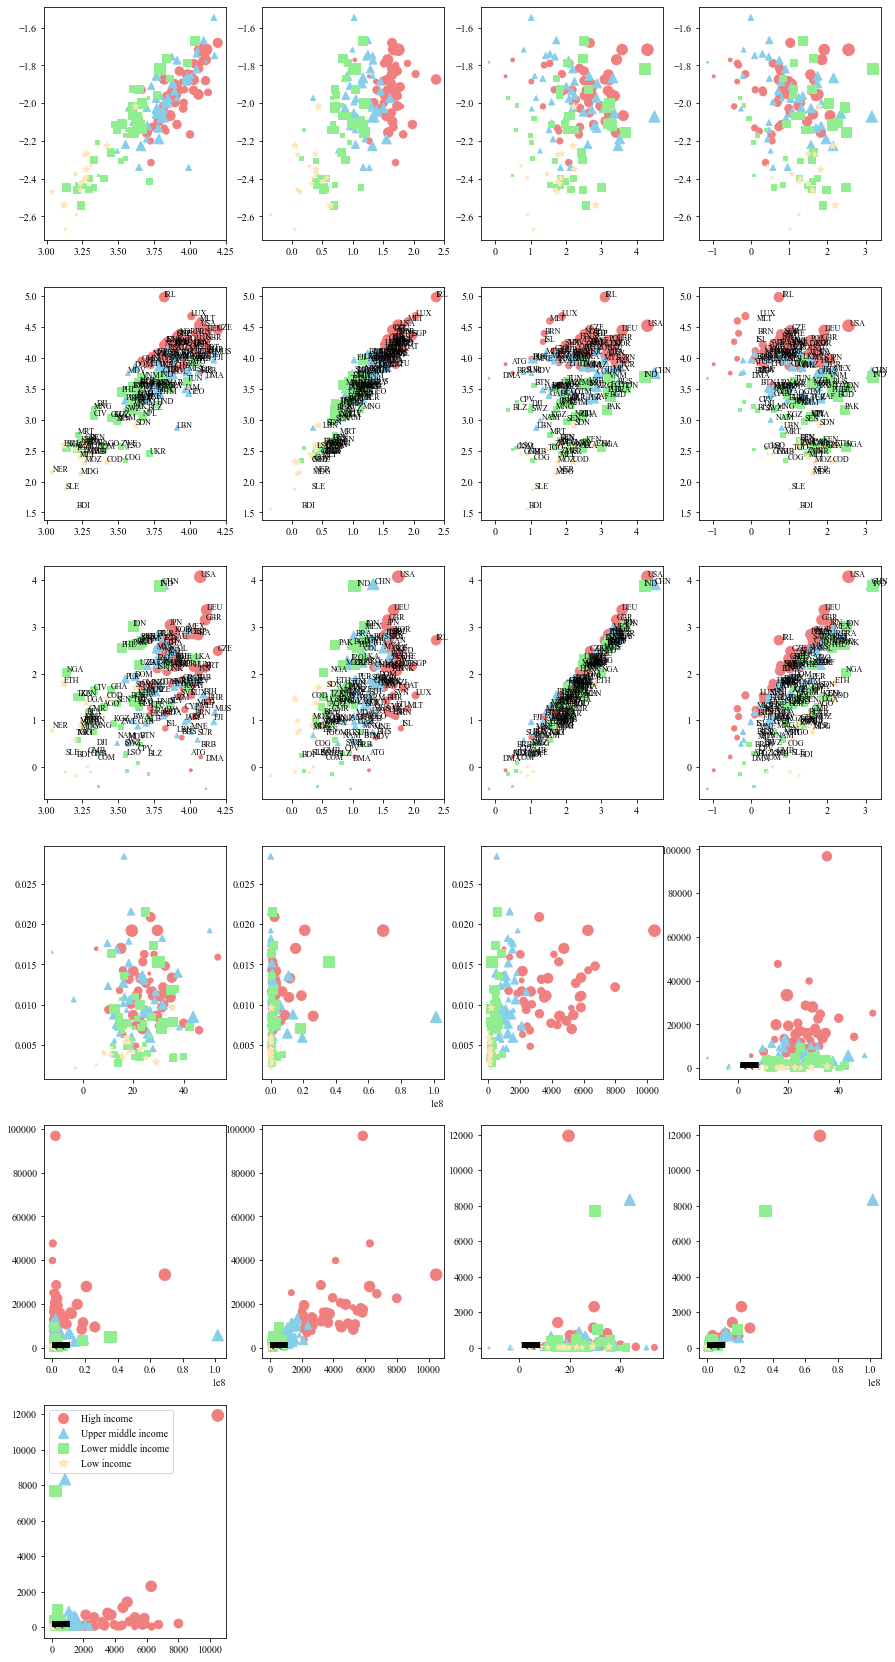

In [50]:
data = df_tax.merge(TOTAL_DATA, on='Country Code')
income = countries_info[['Country Code', 'Income group']]
data = data.merge(income, on='Country Code')

# plt.rcParams['font.family']='Courier New, monospace'
plt.rcParams["font.family"] = "Times New Roman"


colors = {'High income': 'lightcoral', 'Upper middle income' : 'skyblue', 'Lower middle income': 'lightgreen', 
    'Low income': 'moccasin'}
markers = {'High income': 'o', 'Upper middle income' : '^', 'Lower middle income': 's', 
    'Low income': '*'}
income_group = ['High income', 'Upper middle income', 'Lower middle income',  'Low income']
legends = []
for income in income_group:
    legend = mlines.Line2D([], [], color=colors[income], marker=markers[income], linestyle='None',
                        markersize=10, label=income)
    legends.append(legend)
fig = plt.figure(figsize=(15,30))
# 

count = 1
for y_ident in ['tax', 'pc_loss', 'GDPloss']:
    for x_ident in ['Prevalence', 'pc_GDP', 'averageGDP', 'averagePOP']:
        x = data[[x_ident]].apply(np.log10)
        X = sm.add_constant(x)
        y = data[[y_ident]].apply(np.log10)
        ols_model = sm.OLS(y, X)
        ols_results = ols_model.fit()
        print("Parameters: ", ols_results.params)
        print("R2: ", ols_results.rsquared)

        ax = fig.add_subplot(6, 4, count)
        count += 1

        for income in income_group:
            area = data[data['Income group'] == income]
            x = area[[x_ident]].apply(np.log10)
            y = area[[y_ident]].apply(np.log10)
            ax.scatter(x, y, c = colors[income], marker = markers[income], s = 10 * (area['GDPloss'] + 1).apply(np.log2))

        # countries = ['MCO', 'IRL', 'BMU', 'BDI', 'SOM', 'LBN', 'USA', 'CHN', 'IND']
        countries = data['Country Code']
        for country in countries:
            i = data[data['Country Code'] == country].index.values[0]
            x_i, y_i = np.log10(data.loc[i, x_ident] + 1), np.log10(data.loc[i, y_ident] + 1)
            ax.annotate(country, (x_i, y_i), size=8)

for y_ident in ['tax', 'pc_loss', 'GDPloss']:
    for x_ident in ['savings', 'physical', 'he']:
        x = data[[x_ident]]
        X = sm.add_constant(x)
        y = data[[y_ident]]
        ols_model = sm.OLS(y, X)
        ols_results = ols_model.fit()
        print("Parameters: ", ols_results.params)
        print("R2: ", ols_results.rsquared)

        ax = fig.add_subplot(6, 4, count)
        count += 1

        for income in income_group:
            area = data[data['Income group'] == income]
            x = area[[x_ident]]
            y = area[[y_ident]]
            ax.scatter(x, y, c = colors[income], marker = markers[income], s = 10 * (area['GDPloss'] + 1).apply(np.log2))

        # countries = ['MCO', 'IRL', 'BMU', 'BDI', 'SOM', 'LBN', 'USA', 'CHN', 'IND']
        countries = data['Country Code']
        for country in countries:
            i = data[data['Country Code'] == country].index.values[0]
            x_i, y_i = np.log10(data.loc[i, x_ident]), np.log10(data.loc[i, y_ident])
            ax.annotate(country, (x_i, y_i), size=8)

plt.legend(handles=legends)
plt.savefig('tables/figure_tmp_SS.pdf') 